In [3]:
%matplotlib inline

# Huge-scale simulation using Chicago-Sketch dataset

In this example, we demonstrate how UXsim can be used for huge-scale simulation in metropolitan area. We use [Chicago-Sketch](https://github.com/bstabler/TransportationNetworks/tree/master/Chicago-Sketch) dataset provided by Transportation Networks for Research. The scenario data for UXsim is derived from the original TNTP dataset and provided as [chicago_sketch.uxsim_scenario](https://github.com/toruseo/UXsim/blob/main/dat/chicago_sketch.uxsim_scenario) at UXsim repo. The code generated UXsim scenario file is attached to the end of this notebook.

The dataset contains an abstract road network of Chicago metropolitan area with 546 nodes and 2176 links. The traffic demand is almost 1 million vehicles for 1 hour in the peak period. Note that the data is modified from the original dataset in order to make them suitable for UXsim.

With this scale, we cannot simulate each individual vehicle one by one due to extremely high computational cost. Instead, by leveraging the mesoscopic nature of UXsim, we aggregate some vehicles into 1 platoon and simulate their behavior. This is achieved by changing `deltan` argument of `World`. This is very efficient approach as it does not only reduce the number of agents, but also reduce the number of time steps for the same time duration. It is known that the underlying traffic flow model output the equivalent results for within-link traffic dynamics regardless of `deltan` value. The network-scale dynamics will change as this setting alters inter-link traffic behavior, but this can be considered as an acceptable cost for the efficiency.

## Simulation

By loading the pre-defined scenario file `dat/chicago_sketch.uxsim_scenario`, this simulation can be done easily as follows.

In [1]:
from uxsim import *

W = World(
    name="",
    deltan=30, #for huge scale simulation (e.g., 100000+ vehicles or 1000+ links), large deltan is recommended. 
    tmax=10000,
    print_mode=1, save_mode=1, show_mode=1,
    random_seed=42,
)

W.load_scenario("dat/chicago_sketch.uxsim_scenario")

W.exec_simulation()
W.analyzer.print_simple_stats()


loading scenario from 'dat/chicago_sketch.uxsim_scenario'
 DATA SOURCE AND LICENCE : Chicago-Sketch network. This is based on https://github.com/bstabler/TransportationNetworks/tree/master/Chicago-Sketch by Transportation Networks for Research Core Team. Users need to follow their licence. Especially, this data is for academic research purposes only, and users must indicate the source of any dataset they are using in any publication that relies on any of the datasets provided in this web site.
 Number of loaded nodes: 546
 Number of loaded links: 2176
 Number of loaded `adddemand`s: 8406
simulation setting:
 scenario name: 
 simulation duration:	 10000 s
 number of vehicles:	 968520 veh
 total road length:	 12115219.047323605 m
 time discret. width:	 30 s
 platoon size:		 30 veh
 number of timesteps:	 333
 number of platoons:	 32284
 number of links:	 2176
 number of nodes:	 546
 setup time:		 4.39 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|      

You can see that the simulation finishes in about 40 seconds. Now let's visualize the results.

 generating animation...


  0%|          | 0/167 [00:00<?, ?it/s]

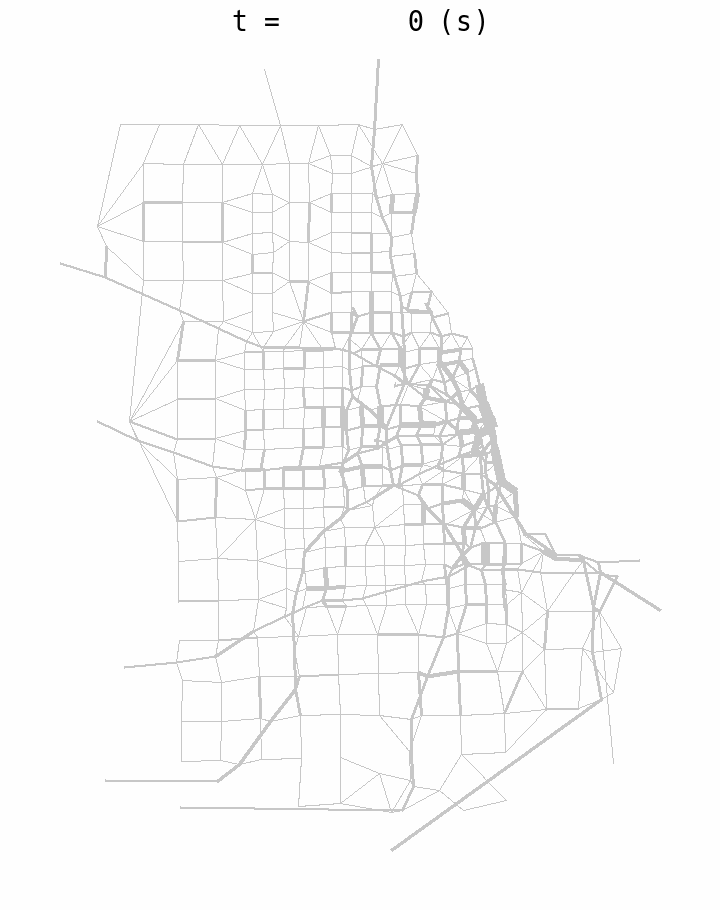

In [4]:
W.analyzer.network_fancy(animation_speed_inverse=10, sample_ratio=0.2, interval=5, trace_length=10, figsize=6, antialiasing=False)
display_image_in_notebook("out/anim_network_fancy.gif")

You can see a peak hour traffic congestion at the downtown area.

## Validation

The original TNTP dataset includes traffic volumes and travel time of every links based on static traffic assignment with a BPR function. Since *static* traffic assignment and *dynamic* traffic assignment of UXsim is substantially different, these results will not match exactly. Nevertheless, it would be worth comparing these results to see whether UXsim outputs plausible results or not.

First, read the link traffic states of UXsim.


In [5]:
df_res_link = W.analyzer.link_to_pandas()
df_res_link

link start_node end_node  traffic_volume  vehicles_remain  \
0      387        388      390             120               90   
1      388        388      391             420                0   
2      389        388      708              90                0   
3      390        388      802               0                0   
4      391        389      390              30                0   
...    ...        ...      ...             ...              ...   
2171  2941        929      442             300                0   
2172  2943        930      518               0                0   
2173  2945        931      906              30                0   
2174  2947        932      515               0                0   
2175  2949        933      534            4980                0   

      free_travel_time  average_travel_time  stddiv_travel_time  
0           665.400000           662.627027            2.699014  
1           358.800000           334.594595           10.561172  
2           174.000000           161.099099           12.496454  
3           286.800000            -1.000000           -1.000000  
4           260.400000           266.655856            4.573892  
...                ...                  ...                 ...  
2171       1322.949900          1347.969212            7.128038  
2172       1543.188079            -1.000000           -1.000000  
2173        911.461779           923.653582            8.796265  
2174        420.142347            -1.000000           -1.000000  
2175        357.600000           407.704505           23.938101  

[2176 rows x 8 columns]

And then TNTP data. 

NOTE: If you want to execute this notebook, please obtain `ChicagoSketch_flow.tntp` and place it to an appropriate path.

In [6]:
df_tntp_flow = pd.read_csv('out/ChicagoSketch_flow.tntp', sep='\t')
df_tntp_flow.columns = ["from", "to", "vol", "min"]
df_tntp_flow["sec"] = df_tntp_flow["min"]*60

display(df_tntp_flow)

from   to       vol        min         sec
0        1  547   4989.13   0.034507    2.070408
1        2  548   6719.41   0.034507    2.070408
2        3  549  10095.53   0.034507    2.070408
3        4  550   9444.62   0.034507    2.070408
4        5  551  17223.82   0.034507    2.070408
...    ...  ...       ...        ...         ...
2945   931  906    157.00  15.707724  942.463430
2946   932  386     25.00   0.034507    2.070408
2947   932  515     22.00   6.347704  380.862240
2948   933  387   5468.00   0.034507    2.070408
2949   933  534   5837.00  13.119813  787.188793

[2950 rows x 5 columns]

In [7]:
from pylab import *

res_tntp = {} #{(start_node, end_node): {}}
res_uxsim = {} #{(start_node, end_node): {}}
for i in lange(df_tntp_flow):
    res_tntp[df_tntp_flow["from"][i], df_tntp_flow["to"][i]] = {"vol": df_tntp_flow["vol"][i], "sec": df_tntp_flow["sec"][i]}
    
for i in lange(df_res_link):
    if df_res_link["traffic_volume"][i] > 0:
        res_uxsim[int(df_res_link["start_node"][i]), int(df_res_link["end_node"][i])] = {"vol": df_res_link["traffic_volume"][i], "sec": df_res_link["average_travel_time"][i]}

for key in list(res_tntp.keys()):
    if key not in res_uxsim.keys():
        del res_tntp[key]
        #print(key, end=", ")
#print("")

for key in list(res_uxsim.keys()):
    if key not in res_tntp.keys():
        del res_tntp[key]
        #print(key, end=", ")

res_tntp_vol = array([res_tntp[key]["vol"] for key in res_uxsim.keys()])
res_uxsim_vol = array([res_uxsim[key]["vol"] for key in res_uxsim.keys()])
res_tntp_sec = array([res_tntp[key]["sec"] for key in res_uxsim.keys()])
res_uxsim_sec = array([res_uxsim[key]["sec"] for key in res_uxsim.keys()])

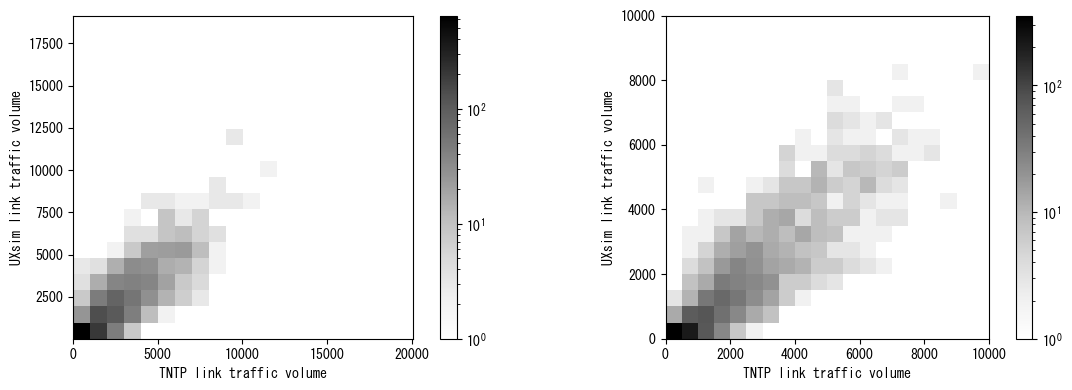

In [8]:
figure(figsize=(12,4))
subplot(121, aspect="equal")
hist2d(res_tntp_vol, res_uxsim_vol, bins=20, cmap="Greys", norm=mpl.colors.LogNorm())
colorbar()
xlabel("TNTP link traffic volume")
ylabel("UXsim link traffic volume")

subplot(122, aspect="equal")
hist2d(res_tntp_vol, res_uxsim_vol, bins=20, range=[[0,10000], [0,10000]], cmap="Greys", norm=mpl.colors.LogNorm())
colorbar()
xlabel("TNTP link traffic volume")
ylabel("UXsim link traffic volume")


tight_layout()
show()

The above figures show the comparison of link traffic volume. Roughly speaking, they are mostly correlated.

all links


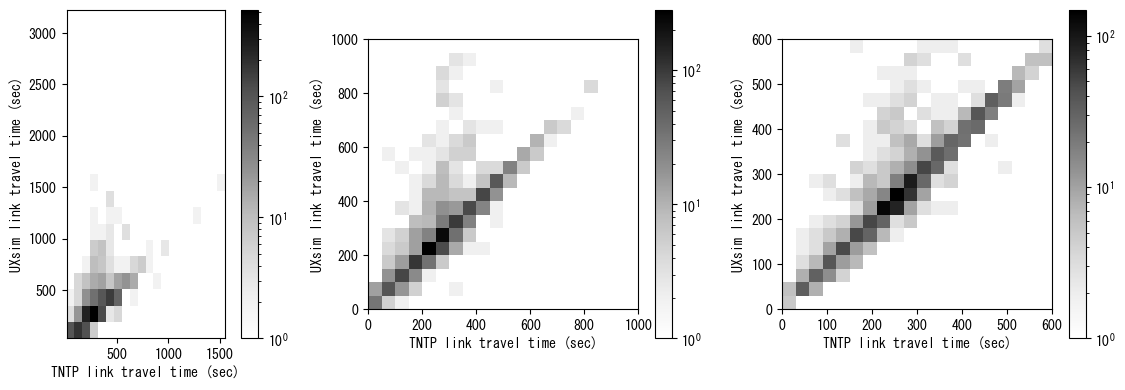

links with non-small traffic volume only. This is because travel time of links with small traffic volume is almost equal to free flow travel time and may not be meaningful comparison


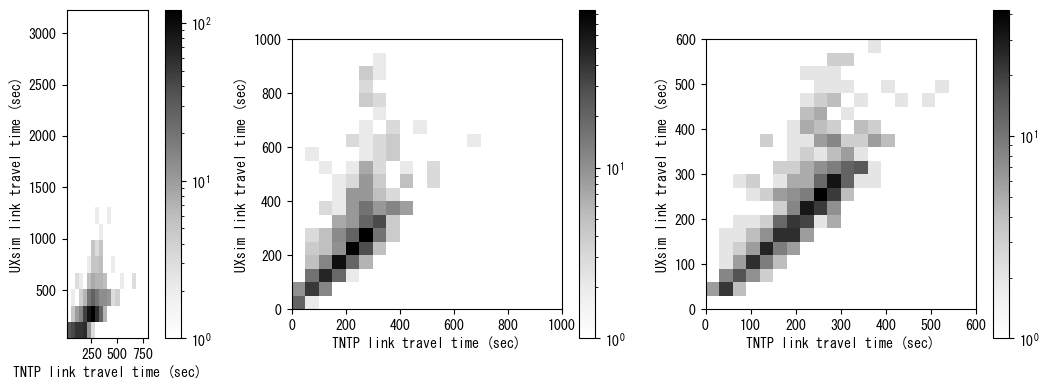

In [39]:
print("all links")
figure(figsize=(12,4))
subplot(131, aspect="equal")
hist2d(res_tntp_sec, res_uxsim_sec, bins=20, cmap="Greys", norm=mpl.colors.LogNorm())
xlabel("TNTP link travel time (sec)")
ylabel("UXsim link travel time (sec)")
colorbar()

subplot(132, aspect="equal")
hist2d(res_tntp_sec, res_uxsim_sec, bins=20, range=[[0,1000], [0,1000]], cmap="Greys", norm=mpl.colors.LogNorm())
xlabel("TNTP link travel time (sec)")
ylabel("UXsim link travel time (sec)")
colorbar()

subplot(133, aspect="equal")
hist2d(res_tntp_sec, res_uxsim_sec, bins=20, range=[[0,600], [0,600]], cmap="Greys", norm=mpl.colors.LogNorm())
xlabel("TNTP link travel time (sec)")
ylabel("UXsim link travel time (sec)")
colorbar()

tight_layout()
show()



print("links with non-small traffic volume only. This is because travel time of links with small traffic volume is almost equal to free flow travel time and may not be meaningful comparison")
threth = 2000 
figure(figsize=(12,4))
subplot(131, aspect="equal")
hist2d(res_tntp_sec[res_tntp_vol>threth], res_uxsim_sec[res_tntp_vol>threth], bins=20, cmap="Greys", norm=mpl.colors.LogNorm())
xlabel("TNTP link travel time (sec)")
ylabel("UXsim link travel time (sec)")
colorbar()

subplot(132, aspect="equal")
hist2d(res_tntp_sec[res_tntp_vol>threth], res_uxsim_sec[res_tntp_vol>threth], bins=20, range=[[0,1000], [0,1000]], cmap="Greys", norm=mpl.colors.LogNorm())
xlabel("TNTP link travel time (sec)")
ylabel("UXsim link travel time (sec)")
colorbar()

subplot(133, aspect="equal")
hist2d(res_tntp_sec[res_tntp_vol>threth], res_uxsim_sec[res_tntp_vol>threth], bins=20, range=[[0,600], [0,600]], cmap="Greys", norm=mpl.colors.LogNorm())
xlabel("TNTP link travel time (sec)")
ylabel("UXsim link travel time (sec)")
colorbar()

tight_layout()
show()


The above figures show the comparison of link traffic travel time. You can see a clear 45-degree line, suggesting that both results are similar for many links. 

However, there is a noticeable difference that many links in UXsim experienced substantially longer travel time than TNTP. This is a reasonable result, because in dynamic traffic assignment with hard traffic capacity, traffic congestion can grow significantly and extend to the upstream links if the demand exceeds the capacity. This kind of realistic phenomena is not captured by the static traffic assignment model.

Now we compare the total travel time in the entire network. As shown in below, the results are not so different. From these results, we can say that UXsim output a plausible result for this scenario.

In [40]:
print("total travel time (h)")
print("TNTP:\t", sum(res_tntp_sec*res_tntp_vol)/3600)
print("UXsim:\t", sum(res_uxsim_sec*res_uxsim_vol)/3600)

total travel time (h)
TNTP:	 311681.3229930834
UXsim:	 347367.7123302059


## Code to translate TNTP files to UXsim scenario

Below if the code used to generate `chicago_sketch.uxsim_scenario` from TNTP datasets.
To execute this code, please obtain TNTP files from [TNTP repo](https://github.com/bstabler/TransportationNetworks) and place them to appropriate path in advance. This code is applicable to other TNTP files with slight modifications.

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from uxsim import *

############################################
# tntp parser customized for Chicago-sketch
############################################

def import_links(filename):
    """
    Modified from `parsing networks in Python.ipynb` in https://github.com/bstabler/TransportationNetworks
    Credit: Transportation Networks for Research Core Team. Transportation Networks for Research. https://github.com/bstabler/TransportationNetworks. Accessed 2021-10-01.
    """
    net = pd.read_csv(filename, skiprows=8, sep='\t')

    trimmed= [s.strip().lower() for s in net.columns]
    net.columns = trimmed

    # And drop the silly first andlast columns
    net.drop(['~', ';'], axis=1, inplace=True)
    return net

def import_nodes(filename):
    """
    Modified from `parsing networks in Python.ipynb` in https://github.com/bstabler/TransportationNetworks
    Credit: Transportation Networks for Research Core Team. Transportation Networks for Research. https://github.com/bstabler/TransportationNetworks. Accessed 2021-10-01. 
    """
    net = pd.read_csv(filename, skiprows=0, sep='\t')

    trimmed= [s.strip().lower() for s in net.columns]
    net.columns = trimmed

    net.drop([';'], axis=1, inplace=True)

    return net

def import_odmatrix_chicago(matfile, nodefile):
    """
    Modified from `parsing networks in Python.ipynb` in https://github.com/bstabler/TransportationNetworks
    Credit: Transportation Networks for Research Core Team. Transportation Networks for Research. https://github.com/bstabler/TransportationNetworks. Accessed 2021-10-01.
    """
    f = open(matfile, 'r')
    all_rows = f.read()
    blocks = all_rows.split('Origin')[1:]
    matrix = {}
    for k in range(len(blocks)):
        orig = blocks[k].split('\n')
        dests = orig[1:]
        orig=int(orig[0])

        d = [eval('{'+a.replace(';',',').replace(' ','') +'}') for a in dests]
        destinations = {}
        for i in d:
            destinations = {**destinations, **i}
        matrix[orig] = destinations
    zones = max(matrix.keys())
    
    # mat = np.zeros((zones, zones))
    # for i in range(zones):
    #     for j in range(zones):
    #         # We map values to a index i-1, as Numpy is base 0
    #         mat[i, j] = matrix.get(i+1,{}).get(j+1,0)

    mat = [[0 for i in range(zones)] for j in range(zones)]
    for i in range(zones):
        for j in range(zones):
            # We map values to a index i-1, as Python is base 0
            mat[i][j] = matrix.get(i+1,{}).get(j+1,0)

    index = np.arange(zones) + 1
    
    nodelist = [i for i in range(387)]#list(import_nodes(nodefile)["node"])

    df = pd.DataFrame(mat, columns=nodelist)
    df["origin"] = nodelist
    df = df.reindex(columns=["origin"]+nodelist)
    return df

df_nodes = import_nodes("_private_files/ChicagoSketch_node.tntp")
df_links = import_links("_private_files/ChicagoSketch_net.tntp")
df_demand = import_odmatrix_chicago("_private_files/ChicagoSketch_trips.tntp", "_private_files/ChicagoSketch_node.tntp")

############################################
# prepare for deleting dummy links/nodes
############################################

map_dummy2real = {}
map_real2dummy = {}
for i in lange(df_links):
    if df_links["capacity"][i] == 49500:    #dummy link between dummy node and real node
        if df_links["init_node"][i] not in map_dummy2real.keys() and df_links["init_node"][i] < df_links["term_node"][i]:
            #print("delete: link", (df_links["init_node"][i], df_links["term_node"][i]), end=", ")
            map_dummy2real[df_links["init_node"][i]] = df_links["term_node"][i]
print("")

############################################
# uxsim setup
############################################


W = World(
    name="",
    deltan=30,
    tmax=10000,
    print_mode=1, save_mode=1, show_mode=1,
    random_seed=42,
    vehicle_logging_timestep_interval=1,
    meta_data = {"DATA SOURCE AND LICENCE": "Chicago-Sketch network. This is based on https://github.com/bstabler/TransportationNetworks/tree/master/Chicago-Sketch by Transportation Networks for Research Core Team. Users need to follow their licence. Especially, this data is for academic research purposes only, and users must indicate the source of any dataset they are using in any publication that relies on any of the datasets provided in this web site."}
)

for i in range(len(df_nodes)):
    if i+1 not in map_dummy2real.keys():
        name = str(i+1)
        x = float(df_nodes["x"][i])
        y = float(df_nodes["y"][i])
        W.addNode(name, x, y)

for i in range(len(df_links)):
    start_node = df_links["init_node"][i]
    end_node = df_links["term_node"][i]

    if start_node in map_dummy2real.keys() or end_node in map_dummy2real.keys():    #delete dummy node
        continue

    length = df_links["length"][i]*1609.34  #mile to m
    if length < 100:
        length = 100
    
    capacity = df_links["capacity"][i]/3600
    n_lanes = int(capacity/0.5) #based on the assumption that flow capacity per lane is 0.5 veh/s in arterial roads
    if n_lanes < 1:
        n_lanes = 1
    if df_links["link_type"][i] == 2:   #highway
        n_lanes = 3
    
    free_flow_time = df_links["free_flow_time"][i]*60
    if free_flow_time > 0:
        free_flow_speed = length/free_flow_time
    else:
        free_flow_speed = 10
    if free_flow_speed < 10:
        free_flow_speed = 10
    elif free_flow_speed > 40:
        free_flow_speed = 40
    
    W.addLink(str(i), str(start_node), str(end_node), length=length, free_flow_speed=free_flow_speed, number_of_lanes=n_lanes)
    

demand_multipiler = 1/0.85  #compensete some demands that are filtered out by pre-processing
demand_threthhold = 30  #delete too small demand (<= deltan) as they cause peculiar traffic pattern at the beginning of simulation
for i in tqdm(range(len(df_demand))):
    origin = str(i+1)
    if int(origin) in map_dummy2real.keys():
        origin = str(map_dummy2real[int(origin)])
    for j in range(len(df_demand)):
        destination = str(j+1)
        
        if int(destination) in map_dummy2real.keys():
            destination = str(map_dummy2real[int(destination)])
        
        if origin == destination:
            continue
        
        demand = df_demand.loc[i, j]*demand_multipiler
        if demand > demand_threthhold:
            try:
                W.adddemand(origin, destination, 0, 3600, volume=demand)
            except:
                print("inconsistent demand:", origin, destination, demand)

W.save_scenario("out/chicago_sketch.uxsim_scenario")

W.exec_simulation()
W.analyzer.print_simple_stats()

W.analyzer.network_fancy(animation_speed_inverse=15, sample_ratio=0.2, interval=5, trace_length=10,  figsize=6, antialiasing=False)